<a href="https://colab.research.google.com/github/ichiP245/TP-Anal-tica-Descriptiva/blob/main/notebooks/TP_Descriptiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis del mercado inmobiliario - Lianjia

### Descripcion sobre las variables

- url (Cualitativa): the url which fetches the data

- id (Cualitativa): the id of transaction

- Lng (Cuantitativa continua): and Lat (Cuantitativa continua) coordinates, using the BD09 protocol.

- Cid (Cualitativa): community id

- tradeTime (Cuantitativa continua): the time of transaction

- DOM (Cuantitativa discreta): active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market

- followers (Cuantitativa discreta): the number of people follow the transaction.

- totalPrice (Cuantitativa continua): the total price

- price (Cuantitativa continua): the average price by square

- square (Cuantitativa continua): the square of house

- livingRoom (Cuantitativa discreta): the number of living room

- drawingRoom (Cuantitativa discreta): the number of drawing room

- kitchen (Cuantitativa discreta): the number of kitchen

- bathroom (Cuantitativa discreta): the number of bathroom

- floor (Cuantitativa discreta): the height of the house. This column is in Chinese characters (they will be replaced by English ones in the next version to be available).

- buildingType (Cualitativa): including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).

- constructionTime (Cuantitativa discreta): the time of construction

- renovationCondition (Cualitativa): including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )

- buildingStructure (Cualitativa): including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).

- ladderRatio (Cuantitativa continua): the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average.

- elevator (Cualitativa): have ( 1 ) or not have elevator( 0 )

- fiveYearsProperty (Cualitativa): if the owner have the property for less than 5 years

- subway (Cualitativa)

- district (Cualitativa)

- communityAverage (Cuantitativa continua)

### Hipotesis:
- Hipótesis 1: Los departamentos de menos ambientes presentan un precio por m² más alto que los de mayor tamaño.
- Hipótesis 2: La superficie es el factor principal del precio.
- Hipótesis 3: La condición de renovación tiene un gran impacto en el precio, pero no del precio por m².
- Hipótesis 4: La cantidad de seguidores tiene una alta correlacion con el precio por m².
- Hipótesis 5: El impacto en el precio por m² de la cercania al metro es más alta en departamentos chicos que grandes.
- Hipotesis 6: hay determinados tipos de construcciones/edificios que solo se relacionan con ciertos rangos de construcción de los edificios

#Importacion de librerias

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import json
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree

#Ingesta de datos

In [166]:
# Leemos el dataset de propiedades inmobiliarias
df = pd.read_csv('new.csv',encoding='GBK')

/tmp/ipython-input-25070946.py:2: DtypeWarning: Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('new.csv',encoding='GBK')


Cargamos dataset de subtes

In [129]:
url = 'https://raw.githubusercontent.com/ichiP245/TP-Anal-tica-Descriptiva/refs/heads/main/data/subway.txt'

In [ ]:
# # Otra forma de abrir los datos del subte
# file = open('/content/subway.txt','r',encoding='utf-8')
# file = file.read()
# file = json.loads(file)
# # file['l'][0]

In [130]:
def get_lines_stations_info(url_text):
    #解析text数据，将其变成字典数据 -> #Analizar datos de texto y convertirlos en datos de diccionario
    data = pd.read_json(url, encoding='utf-8')
    beijing_subway = data['l'].to_dict()
    pass

    # 遍历json数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    # ->
    # Recorrer los datos JSON y construir una estructura de datos de ubicación
    # Un diccionario con toda la información de la ruta: clave: nombre de la ruta; valor: lista de nombres de estaciones
    lines_info = {}

    for line in range(len(beijing_subway)):
        line_key = beijing_subway[line]['ln']
        line_value = []
        for station in range(len(beijing_subway[line]['st'])):
            line_value.append(beijing_subway[line]['st'][station]['n'])
        lines_info[line_key] = line_value

    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    # Un diccionario de toda la información del sitio: clave: nombre del sitio; valor: coordenadas del sitio (x, y)
    stations_info = {}

    for line in range(len(beijing_subway)):
        for station in range(len(beijing_subway[line]['st'])):
            station_key = beijing_subway[line]['st'][station]['n']
            station_value = eval(beijing_subway[line]['st'][station]['sl'])
            stations_info[station_key] = station_value

    return lines_info,stations_info

lines_info, stations_info = get_lines_stations_info(url)

In [131]:
# Vemos las dos primeras estaciones con sus ubicaciones
list(stations_info.items())[:2]

[('金安桥', (116.163167, 39.92362)), ('四道桥', (116.13401, 39.91603))]

In [132]:
len(stations_info)

340

In [133]:
datos_df = {'Estacion': list(), 'Latitud': list(), 'Longitud': list()}
for estacion in stations_info:
  datos_df['Estacion'] = datos_df['Estacion'] + [estacion]
  datos_df['Latitud'] = datos_df['Latitud'] + [stations_info[estacion][1]]
  datos_df['Longitud'] = datos_df['Longitud'] + [stations_info[estacion][0]]
df_subte = pd.DataFrame(datos_df)

A partir de ahora hacemos el analisis sobre el dataset de propiedades inmobiliarias

### Formato del dataset

In [ ]:
# Primeras filas
df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [ ]:
# Filas y columnas
df.shape

(318851, 26)

In [ ]:
# Columnas y tipos de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

### Estadisticos principales

In [ ]:
# Tenemos un problema. Hay columnas que no detecto como numericas
# -> vamos a tener que limpiarlas y despues volver a realizar el analisis de estadisticos

# Ademas, van a haber variables que son categoricas y han sido pasadas a numericas, que no tiene sentido hacerles un analisis de estadisticos
df.select_dtypes('number').columns

Index(['Lng', 'Lat', 'Cid', 'DOM', 'followers', 'totalPrice', 'price',
       'square', 'kitchen', 'buildingType', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'district', 'communityAverage'],
      dtype='object')

In [ ]:
# La numericas son estas
lista_numericas = ['Lng', 'Lat', 'tradeTime', 'DOM', 'followers', 'totalPrice', 'price', 'square',
                   'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'floor', 'constructionTime', 'ladderRatio', 'communityAverage']

In [ ]:
df[lista_numericas].select_dtypes(include=('number')).describe()

,Lng,Lat,DOM,followers,totalPrice,price,square,kitchen,ladderRatio,communityAverage
count,318851.000000,318851.000000,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,3.188510e+05,318388.000000
mean,116.418459,39.949591,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,6.316486e+01,63682.446305
std,0.112054,0.091983,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,2.506851e+04,22329.215447
min,116.072514,39.627030,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,0.000000e+00,10847.000000
25%,116.344985,39.893200,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,2.500000e-01,46339.000000
50%,116.416780,39.934527,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,3.330000e-01,59015.000000
75%,116.477581,40.003018,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,5.000000e-01,75950.000000
max,116.732378,40.252758,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,1.000940e+07,183109.000000


### Analisis faltantes

Previo a analizar los faltantes, vamos a analizar variable por variable a ver si aparecen posibles nulos

In [ ]:
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
[101084782030 101086012217 101086041636 ... 'BJYZ92324217' 'BJYZ92333313'
 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
['2016-08-09' '2016-07-28' '2016-12-11' ... '2012-01-28' '2011-01-30'
 '2009-01-11']

DOM
[1.464e+03 9.030e+02 1.271e+03 9.650e+02 9.270e+02 8.610e+02 8.510e+02
 9.040e+02 8.730e+02 8.650e+02 8.270e+02 7.730e+02 7.930e+02 7.840e+02
 7.060e+02 8.000e+02 7.390e+02 7.900e+02 6.910e+02 7.470e+02 6.900e+02
 6.970e+02 6.8

Como se puede ver aparecen muchos caracteres raros, vamos a analizar las filas que los contienen y los que no

In [ ]:
# Vemos las filas que tienen valores extraños o incoherentes en la columna 'bathRoom'
df[df['bathRoom'].isin([2006, 2003, 1990, 2000, 1996, 2005, 2011, '未知', 1994, 2004, '2003'])]

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
92235,https://bj.lianjia.com/chengjiao/BJ0000615040....,BJ0000615040,116.117724,39.941152,1111052110644,2010-02-21,1.0,0,198.0,15729,...,0.500,1,0,0,0.0,NaN,NaN,NaN,12,39492.0
92251,https://bj.lianjia.com/chengjiao/BJ0000615084....,BJ0000615084,116.121964,39.939762,1111027375862,2010-03-07,1.0,0,136.0,14601,...,0.333,1,0,0,0.0,NaN,NaN,NaN,12,37588.0
92267,https://bj.lianjia.com/chengjiao/BJ0000615132....,BJ0000615132,116.118409,39.937888,1111043529456,2010-03-22,1.0,0,127.0,14613,...,0.333,1,0,0,0.0,NaN,NaN,NaN,12,38753.0
92270,https://bj.lianjia.com/chengjiao/BJ0000615138....,BJ0000615138,116.111318,39.949921,1111027377794,2010-03-23,1.0,0,115.0,14240,...,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36923.0
92297,https://bj.lianjia.com/chengjiao/BJ0000615208....,BJ0000615208,116.117724,39.941152,1111052110644,2010-04-10,1.0,0,100.0,17242,...,0.125,1,0,0,0.0,NaN,NaN,NaN,12,39492.0
92299,https://bj.lianjia.com/chengjiao/BJ0000615220....,BJ0000615220,116.111318,39.949921,1111027377794,2010-04-13,1.0,0,205.0,13021,...,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36923.0
92300,https://bj.lianjia.com/chengjiao/BJ0000615222....,BJ0000615222,116.118409,39.937888,1111043529456,2010-04-13,1.0,0,146.5,15985,...,0.500,1,0,0,0.0,NaN,NaN,NaN,12,38753.0
92304,https://bj.lianjia.com/chengjiao/BJ0000615229....,BJ0000615229,116.117019,39.933860,1111052073923,2010-04-17,1.0,0,90.0,14288,...,0.333,0,0,0,0.0,NaN,NaN,NaN,12,39381.0
92340,https://bj.lianjia.com/chengjiao/BJ0000615401....,BJ0000615401,116.122354,39.937384,1111027376723,2010-09-09,1.0,0,130.0,17640,...,0.500,0,0,0,0.0,NaN,NaN,NaN,12,36358.0
92349,https://bj.lianjia.com/chengjiao/BJ0000615438....,BJ0000615438,116.117724,39.941152,1111052110644,2010-09-29,1.0,0,109.5,17484,...,0.125,1,0,0,0.0,NaN,NaN,NaN,12,39492.0


In [ ]:
# Nos quedamos con los registros que NO tienen valores extraños en 'bathRoom' y vemos que las
# columnas que cuando antes hicimos .unique() tenian valores raros, ahora desaparecieron
df1 = df.loc[~df['bathRoom'].isin([2006, 2003, 1990, 2000, 1996, 2005, 2011, '未知', 1994, 2004, '2003',])]
print(df1['livingRoom'].unique())
print(df1['drawingRoom'].unique())
print(df1['buildingType'].unique())
print(df1['floor'].unique())

[2 3 1 4 5 6 9 0 7 8 '1' '4' '3' '2' '5' '7' '9' '6' '0' '8']
[1 2 0 4 3 5 '0' '1' '2' '3' '4' '5']
[ 1.  4.  3. nan  2.]
['高 26' '高 22' '中 4' '底 21' '中 6' '中 8' '高 6' '高 10' '中 23' '底 11' '底 3'
 '高 24' '低 23' '中 19' '高 18' '低 25' '中 12' '中 14' '中 30' '中 27' '中 5'
 '低 18' '底 28' '中 11' '低 9' '顶 7' '顶 27' '低 6' '中 17' '顶 6' '中 24' '中 15'
 '底 5' '中 29' '顶 19' '顶 5' '中 9' '低 22' '顶 18' '低 16' '高 13' '高 9' '高 17'
 '底 6' '中 28' '低 26' '底 15' '高 16' '底 2' '低 7' '中 13' '低 33' '底 14' '高 15'
 '底 4' '顶 11' '中 32' '顶 16' '底 18' '顶 17' '低 14' '低 10' '底 20' '高 12'
 '低 31' '低 30' '低 19' '低 12' '中 10' '中 16' '顶 20' '底 19' '中 31' '低 13'
 '底 10' '高 25' '中 21' '中 20' '高 20' '低 21' '低 24' '顶 4' '高 21' '高 7'
 '中 22' '底 1' '中 7' '底 8' '顶 15' '中 18' '高 28' '顶 14' '顶 13' '低 20' '底 26'
 '低 17' '顶 24' '底 23' '顶 3' '顶 21' '底 24' '高 30' '高 11' '底 25' '高 27'
 '底 9' '低 11' '低 28' '低 15' '顶 26' '低 34' '顶 12' '中 25' '高 8' '底 17'
 '高 32' '高 19' '底 7' '顶 28' '顶 9' '高 31' '中 26' '顶 2' '顶 8' '底 32' '中 42'
 '底 30' '低 32'

Se pudo ver que todas las filas que tenian caracteres raros o sin sentido, los tenian en muchas columnas, como 'bathRoom' siendo un año, 'livingRoom' siendo #NAME, drawingRoom con simbolos raros, 'floor' siendo letras y 'buildingType' no siendo un entero como corresponde. En cambio cuando vemos el dataset sin estas filas, todos los valores quedan con el mismo formato y sin caracteres raros a excepcion de 'floor' que la investigaremos luego.

Por lo que, vamos a truncar todas las filas con esos caracteres raros.

In [ ]:
df = df1

Hacemos el mismo analisis pero sin las filas eliminadas

In [ ]:
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
[101084782030 101086012217 101086041636 ... 'BJYZ92324217' 'BJYZ92333313'
 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
['2016-08-09' '2016-07-28' '2016-12-11' ... '2012-01-28' '2011-01-30'
 '2009-01-11']

DOM
[1.464e+03 9.030e+02 1.271e+03 9.650e+02 9.270e+02 8.610e+02 8.510e+02
 9.040e+02 8.730e+02 8.650e+02 8.270e+02 7.730e+02 7.930e+02 7.840e+02
 7.060e+02 8.000e+02 7.390e+02 7.900e+02 6.910e+02 7.470e+02 6.900e+02
 6.970e+02 6.8

Se puede ver que hay variables que tienen distintos tipos de datos, en DOM y en buildingType aparece el valor nan y en constructionTime aparece '未知' que al traducirlo significa 'desconocido'.

In [ ]:
display(df[['DOM','buildingType']].isna().sum())
display(df['DOM'].value_counts())
df['buildingType'].value_counts()


,0
DOM,157970
buildingType,2021


,count
DOM,
1.0,69137
5.0,2352
4.0,2317
3.0,2313
6.0,2194
...,...
381.0,1
1352.0,1
1401.0,1


,count
buildingType,
4.0,172405
1.0,84541
3.0,59715
2.0,137


En DOM y en buildingType aparece el valor nan al hacer .unique() pero son datos que realmente son NaN para el programa, porque cuando hacemos el .value_counts() no aparecen.

In [ ]:
df[df['constructionTime']=='未知']

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
41,https://bj.lianjia.com/chengjiao/101088892742....,101088892742,116.232365,40.235529,1111027380837,2016-08-03,546.0,6,170.0,22078,...,4.0,未知,1,2,0.333,0.0,1.0,0.0,6,35347.0
82,https://bj.lianjia.com/chengjiao/101089360053....,101089360053,116.249496,40.221791,1111027378945,2016-07-26,457.0,4,360.0,24507,...,4.0,未知,4,2,0.500,0.0,1.0,0.0,6,37612.0
101,https://bj.lianjia.com/chengjiao/101089448850....,101089448850,116.523870,39.923283,1111027374597,2016-07-16,430.0,3,470.0,32794,...,1.0,未知,3,6,0.500,1.0,1.0,1.0,7,30864.0
158,https://bj.lianjia.com/chengjiao/101089726827....,101089726827,116.430012,40.066244,1111027380045,2016-10-31,487.0,52,580.0,20579,...,4.0,未知,3,2,0.500,0.0,1.0,0.0,6,39940.0
160,https://bj.lianjia.com/chengjiao/101089729474....,101089729474,116.520858,39.918846,1111027377634,2016-07-28,392.0,222,330.0,29483,...,4.0,未知,2,2,0.500,0.0,1.0,1.0,7,56752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318825,https://bj.lianjia.com/chengjiao/BJYZ92198713....,BJYZ92198713,116.508181,39.807662,1111027374693,2016-06-04,NaN,9,70.0,20984,...,1.0,未知,3,6,0.200,1.0,0.0,1.0,3,28609.0
318828,https://bj.lianjia.com/chengjiao/BJYZ92209519....,BJYZ92209519,116.497474,39.810115,1111027377957,2016-06-10,1.0,7,98.5,27218,...,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0
318833,https://bj.lianjia.com/chengjiao/BJYZ92225970....,BJYZ92225970,116.497474,39.810115,1111027377957,2016-05-22,1.0,3,147.0,26602,...,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0
318839,https://bj.lianjia.com/chengjiao/BJYZ92258549....,BJYZ92258549,116.497474,39.810115,1111027377957,2016-05-28,1.0,1,145.0,26221,...,1.0,未知,4,6,0.250,1.0,0.0,1.0,3,54282.0


Consideramos que el hecho de que no se conoce el año de construccion es algo importante y que seguramente se deba a que son edificios antiguos. Por lo que una buena solucion es a estos datos aplicarle KNN. Los vamos a transformar a nulos ya que no hay otros valores nulos en esa columna. Por lo que un nulo en constructionTime ahora significa que es desconocido.

In [ ]:
# Transformamos a nan los valores con '未知'
df['constructionTime'] = df['constructionTime'].replace('未知', np.nan)

In [ ]:
columnas_faltantes = []
print('Columna, cantidad de faltantes, porcentaje del total')

for columna in df:

    total = len(df[columna])
    cant_faltantes = df[columna].isna().sum()

    if cant_faltantes > 0:
        columnas_faltantes.append(columna)
        print(columna, cant_faltantes, cant_faltantes/total, sep=', ')

Columna, cantidad de faltantes, porcentaje del total
DOM, 157970, 0.49548489895520653
buildingType, 2021, 0.00633901994548631
constructionTime, 19283, 0.0604825935719013
communityAverage, 463, 0.0014522346535181404


Convertimos los datos a su tipo correcto

In [ ]:
df['id'] = df['id'].astype(str)
df['tradeTime'] = pd.to_datetime(df['tradeTime'])
df['livingRoom'] = df['livingRoom'].astype(int)
df['drawingRoom'] = df['drawingRoom'].astype(int)
df['bathRoom'] = df['bathRoom'].astype(int)
df['buildingType'] = df['buildingType'].astype(float)
df['constructionTime'] = df['constructionTime'].astype(float)

Identificamos que el precio esta reducido a 10 miles. Por lo que lo volvemos a calcular a partir del precio por square y el square.

In [ ]:
df[['price','totalPrice','square']].head()

,price,totalPrice,square
0,31680,415.0,131.00
1,43436,575.0,132.38
2,52021,1030.0,198.00
3,22202,297.5,134.00
4,48396,392.0,81.00


In [ ]:
df['totalPrice'] = df['price']*df['square']

In [ ]:
df[['price','totalPrice','square']].head()

,price,totalPrice,square
0,31680,4150080.00,131.00
1,43436,5750057.68,132.38
2,52021,10300158.00,198.00
3,22202,2975068.00,134.00
4,48396,3920076.00,81.00


In [ ]:
# Identificamos que se haya producido el cambio en el tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318819 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   url                  318819 non-null  object        
 1   id                   318819 non-null  object        
 2   Lng                  318819 non-null  float64       
 3   Lat                  318819 non-null  float64       
 4   Cid                  318819 non-null  int64         
 5   tradeTime            318819 non-null  datetime64[ns]
 6   DOM                  160849 non-null  float64       
 7   followers            318819 non-null  int64         
 8   totalPrice           318819 non-null  float64       
 9   price                318819 non-null  int64         
 10  square               318819 non-null  float64       
 11  livingRoom           318819 non-null  int64         
 12  drawingRoom          318819 non-null  int64         
 13  kitchen            

In [ ]:
# Hacemos analisis de valores unicos nuevamente
for columna in df:
    print(columna)
    print(df[columna].unique())
    print()

url
['https://bj.lianjia.com/chengjiao/101084782030.html'
 'https://bj.lianjia.com/chengjiao/101086012217.html'
 'https://bj.lianjia.com/chengjiao/101086041636.html' ...
 'https://bj.lianjia.com/chengjiao/BJYZ92324217.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92333313.html'
 'https://bj.lianjia.com/chengjiao/BJYZ92363553.html']

id
['101084782030' '101086012217' '101086041636' ... 'BJYZ92324217'
 'BJYZ92333313' 'BJYZ92363553']

Lng
[116.475489 116.453917 116.561978 ... 116.364322 116.399965 116.376828]

Lat
[40.01952  39.881534 39.877145 ... 39.933002 39.952619 39.93465 ]

Cid
[1111027376244 1111027381879 1111040862969 ... 1111027378919 1111027381192
 1111027381198]

tradeTime
<DatetimeArray>
['2016-08-09 00:00:00', '2016-07-28 00:00:00', '2016-12-11 00:00:00',
 '2016-09-30 00:00:00', '2016-08-28 00:00:00', '2016-07-22 00:00:00',
 '2016-07-14 00:00:00', '2016-09-07 00:00:00', '2016-09-04 00:00:00',
 '2016-09-05 00:00:00',
 ...
 '2011-06-03 00:00:00', '2011-08-08 00:00:00', '2011-03-

In [ ]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage'],
      dtype='object')

livingRoom


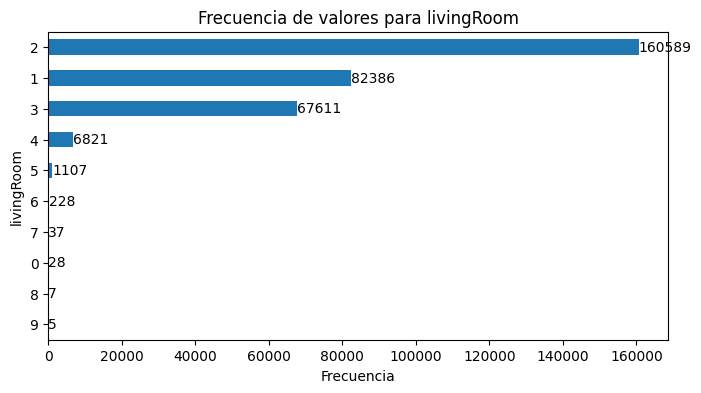


drawingRoom


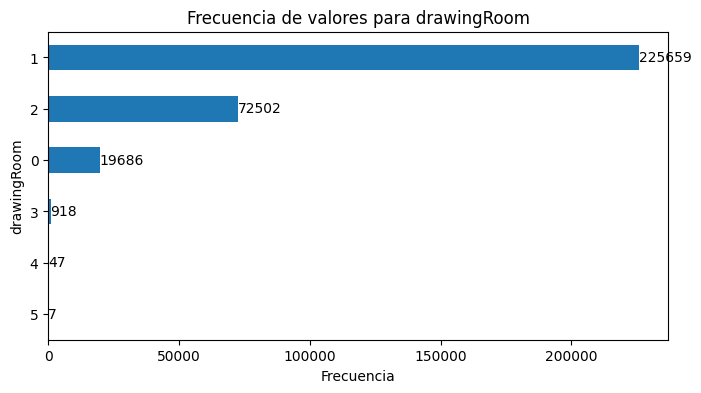


kitchen


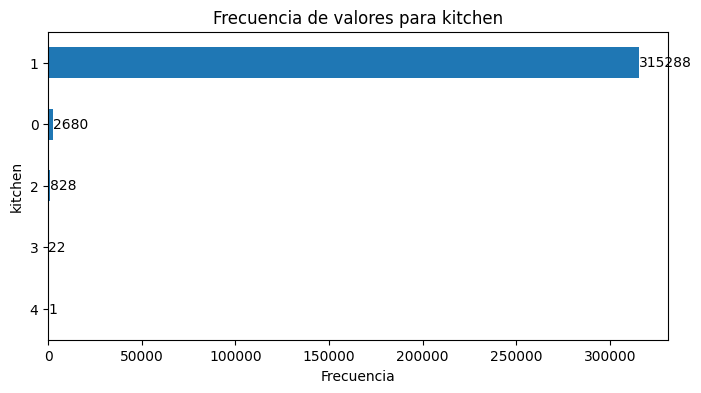


bathRoom


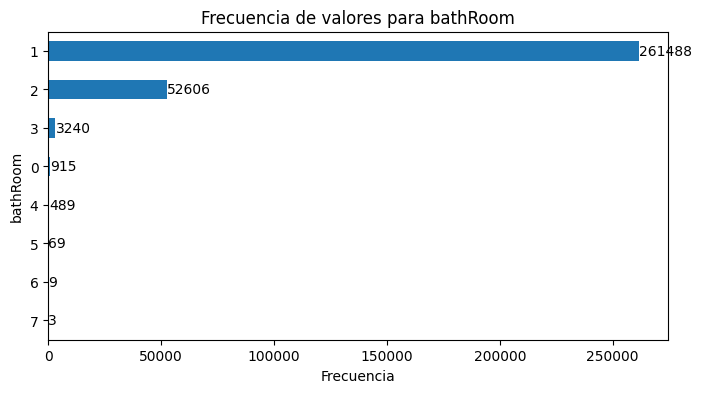


buildingType


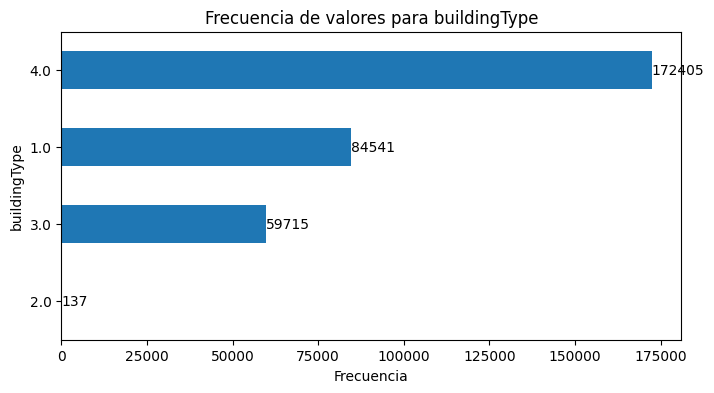


renovationCondition


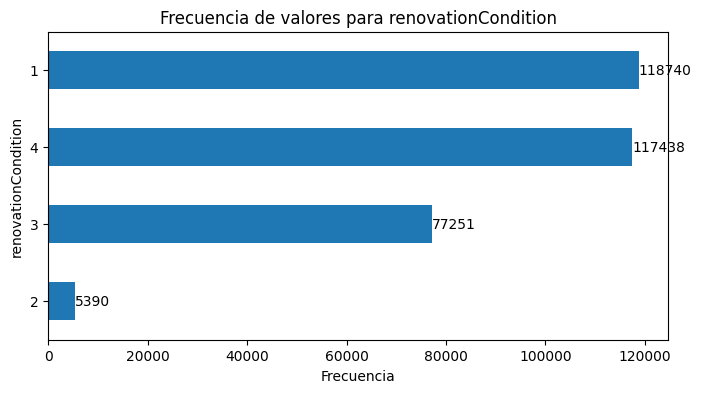


buildingStructure


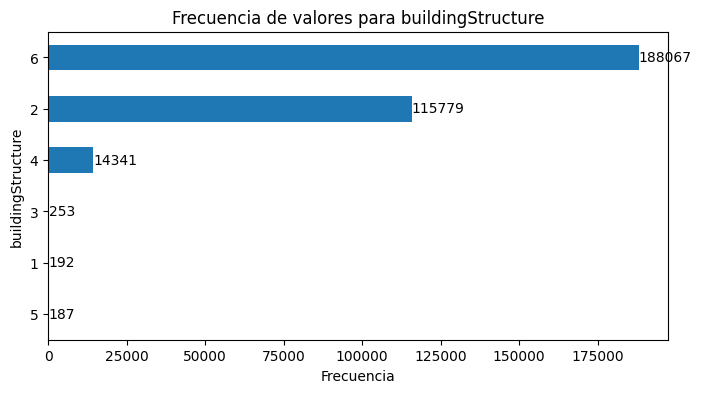


elevator


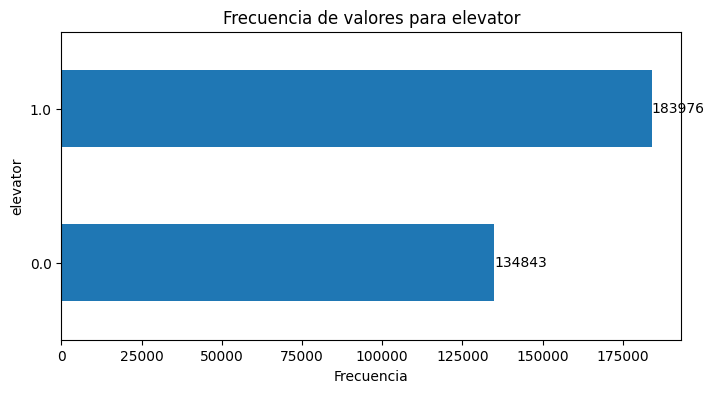


fiveYearsProperty


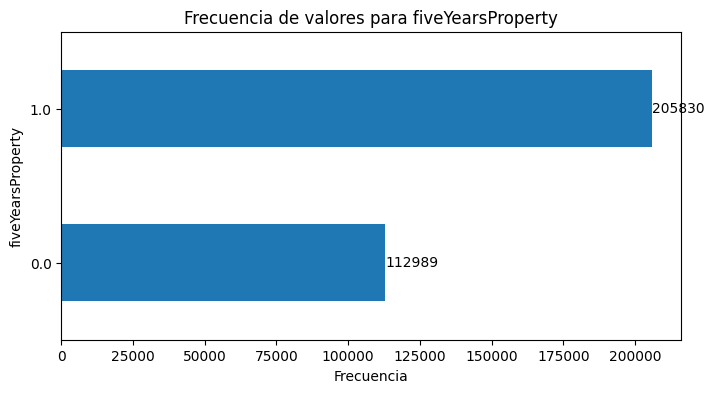


subway


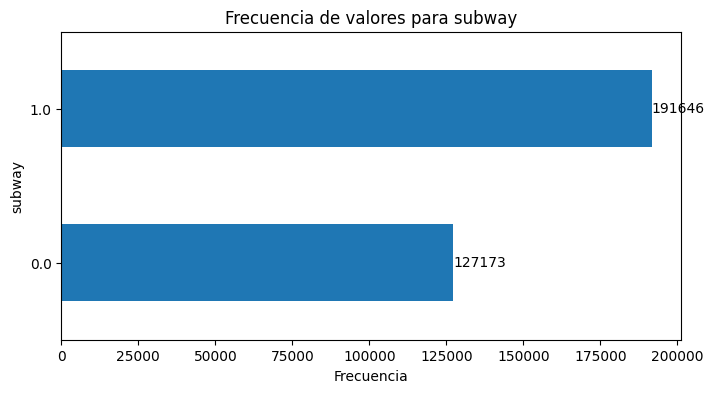


district


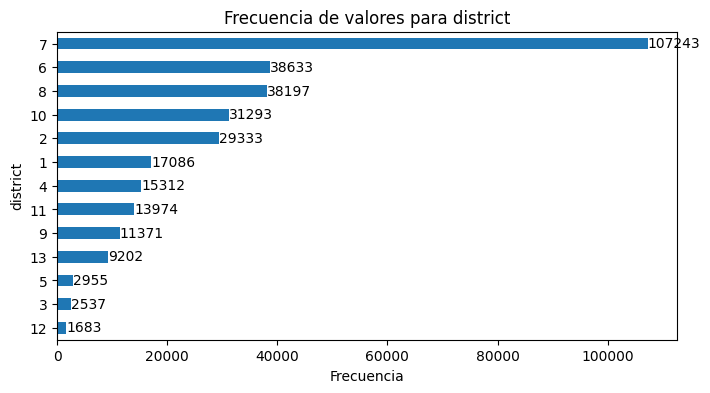

In [ ]:
# Para algunas variables, vemos la frecuencia de sus valores
vars = ['livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'buildingType', 'renovationCondition', 'buildingStructure', 'elevator',
       'fiveYearsProperty', 'subway', 'district']
for var in vars:
    print(var)
    value_counts = df[var].value_counts()
    # print(value_counts)
    plt.figure(figsize=(8, 4))
    value_counts.plot(kind='barh')
    plt.title(f'Frecuencia de valores para {var}')
    plt.xlabel('Frecuencia')
    plt.ylabel(var)
    # Invertir eje y
    plt.gca().invert_yaxis()
    # Agregar etiquetas de los valores
    for index, value in enumerate(value_counts):
        plt.text(value, index, str(value), ha='left', va='center')
    plt.show()
    print()

No se observan valores extraños o incoherentes

In [ ]:
# Volvemos a hacer analisis de estadisticos principales, solo para variables cuantitativas
df[lista_numericas].select_dtypes(include=['number','datetime']).describe()

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,constructionTime,ladderRatio,communityAverage
count,318819.000000,318819.000000,318819,160849.000000,318819.000000,3.188190e+05,318819.000000,318819.000000,318819.000000,318819.000000,318819.000000,318819.000000,299536.000000,3.188190e+05,318356.000000
mean,116.418483,39.949593,2015-04-17 23:51:05.858684672,28.826664,16.733187,3.490554e+06,43533.066746,83.241400,2.010370,1.171950,0.994338,1.188122,1999.216021,6.317120e+01,63684.226787
min,116.072514,39.627030,2002-06-01 00:00:00,1.000000,0.000000,1.500000e+01,1.000000,6.900000,0.000000,0.000000,0.000000,0.000000,1906.000000,1.400000e-02,10847.000000
25%,116.344985,39.893200,2013-11-30 12:00:00,1.000000,0.000000,2.050002e+06,28052.500000,57.900000,1.000000,1.000000,1.000000,1.000000,1994.000000,2.500000e-01,46339.000000
50%,116.416780,39.934527,2015-09-12 00:00:00,6.000000,5.000000,2.940031e+06,38738.000000,74.260000,2.000000,1.000000,1.000000,1.000000,2001.000000,3.330000e-01,59015.000000
75%,116.477581,40.003018,2016-07-31 00:00:00,37.000000,18.000000,4.255073e+06,53821.000000,98.710000,2.000000,1.000000,1.000000,1.000000,2006.000000,5.000000e-01,75950.000000
max,116.732378,40.252758,2018-01-28 00:00:00,1677.000000,1143.000000,1.813016e+08,156250.000000,1745.500000,9.000000,5.000000,4.000000,7.000000,2016.000000,1.000940e+07,183109.000000
std,0.112031,0.091985,NaN,50.240049,34.210491,2.307811e+06,21708.374706,37.234963,0.776822,0.522287,0.106185,0.437544,8.777396,2.506976e+04,22328.807086


#Analisis de duplicados

In [ ]:
df.duplicated().sum()

np.int64(0)

Se puede ver que no hay registros enteros duplicados. Verificamos ahora si hay 2 con mimso ID.

In [ ]:
df['id'].duplicated().sum()

np.int64(0)

Comprobamos que no hay duplicados

#Analisis de outliers

In [ ]:
# Pasamos fecha a numero
df['tradeTime'] = df['tradeTime'].apply(lambda x: x.toordinal())

In [ ]:
# Chequeamos que las columnas cuantitativas tengan tipo de dato numerico
df[lista_numericas].info()

<class 'pandas.core.frame.DataFrame'>
Index: 318819 entries, 0 to 318850
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Lng               318819 non-null  float64
 1   Lat               318819 non-null  float64
 2   tradeTime         318819 non-null  int64  
 3   DOM               160849 non-null  float64
 4   followers         318819 non-null  int64  
 5   totalPrice        318819 non-null  float64
 6   price             318819 non-null  int64  
 7   square            318819 non-null  float64
 8   livingRoom        318819 non-null  int64  
 9   drawingRoom       318819 non-null  int64  
 10  kitchen           318819 non-null  int64  
 11  bathRoom          318819 non-null  int64  
 12  floor             318819 non-null  object 
 13  constructionTime  299536 non-null  float64
 14  ladderRatio       318819 non-null  float64
 15  communityAverage  318356 non-null  float64
dtypes: float64(8), int64(7), 

In [ ]:
lista_numericas.remove('floor')

Variable Lng tiene un p-valor de normalidad de 0.0


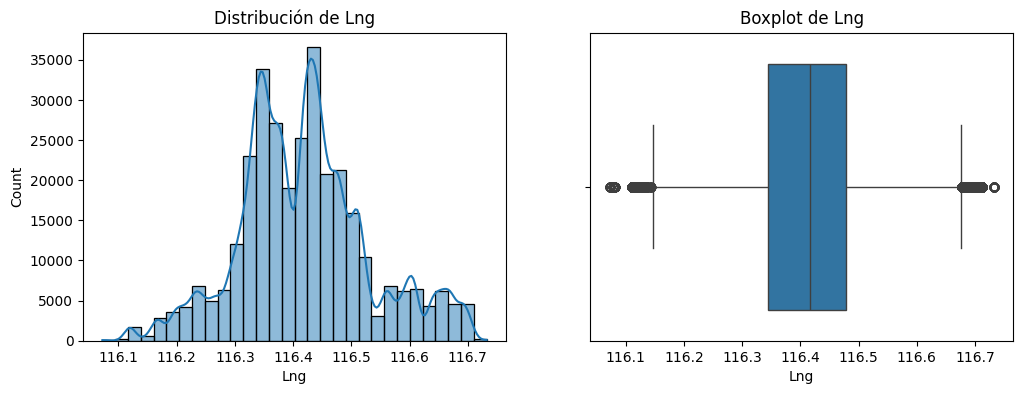

Variable Lat tiene un p-valor de normalidad de 0.0


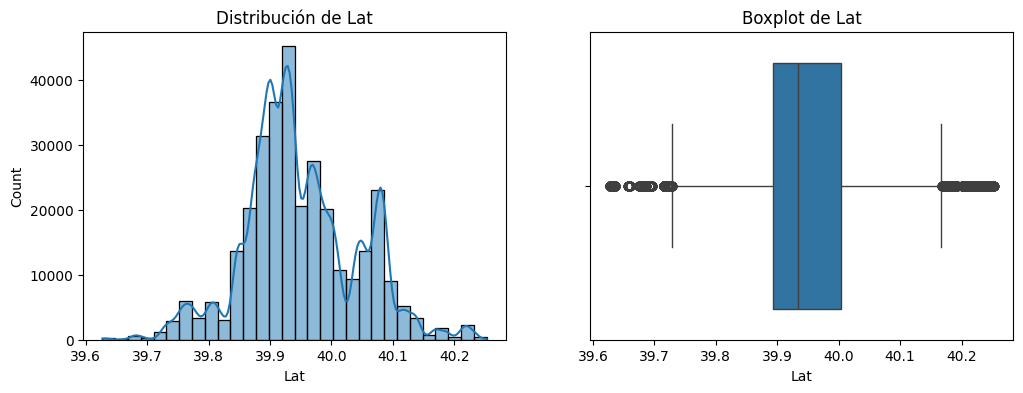

Variable tradeTime tiene un p-valor de normalidad de 0.0


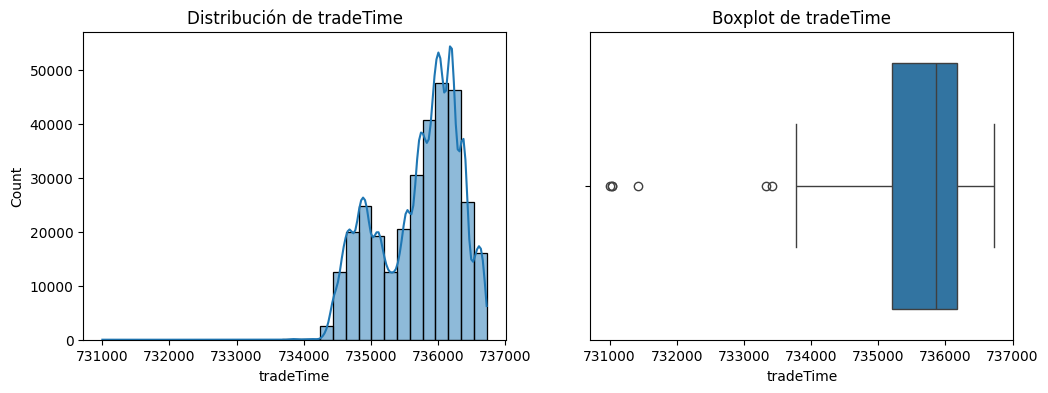

Variable DOM tiene un p-valor de normalidad de 0.0


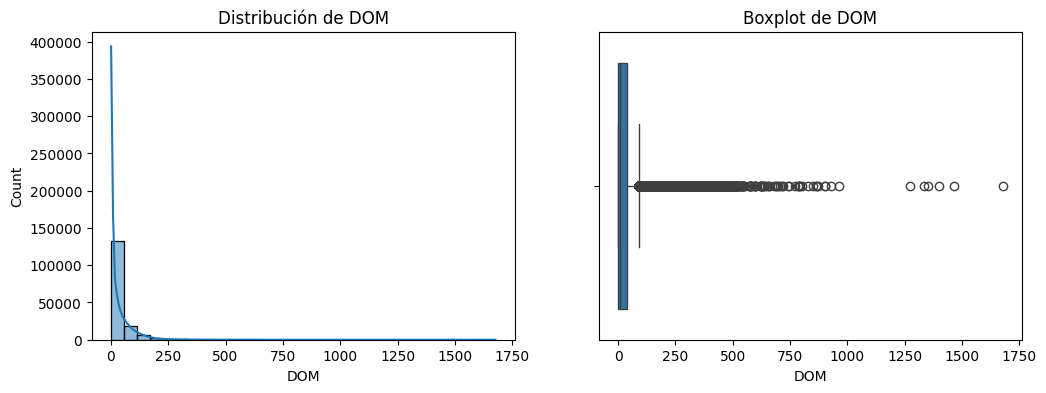

Variable followers tiene un p-valor de normalidad de 0.0


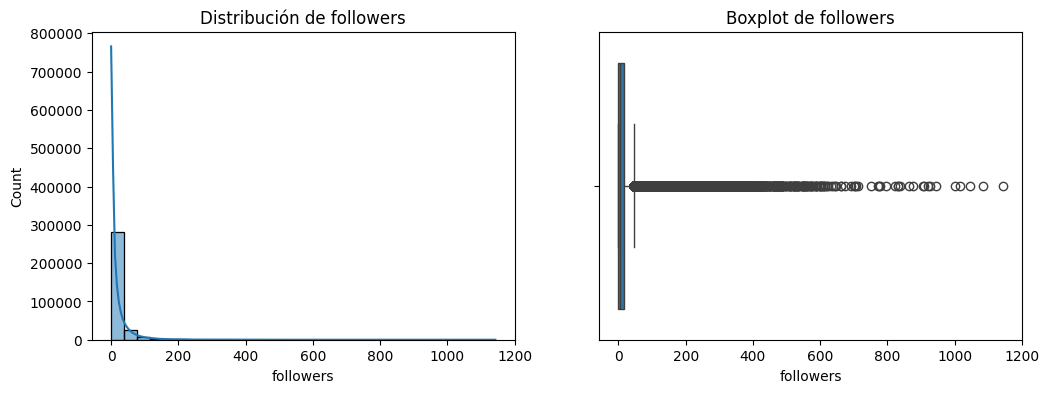

Variable totalPrice tiene un p-valor de normalidad de 0.0


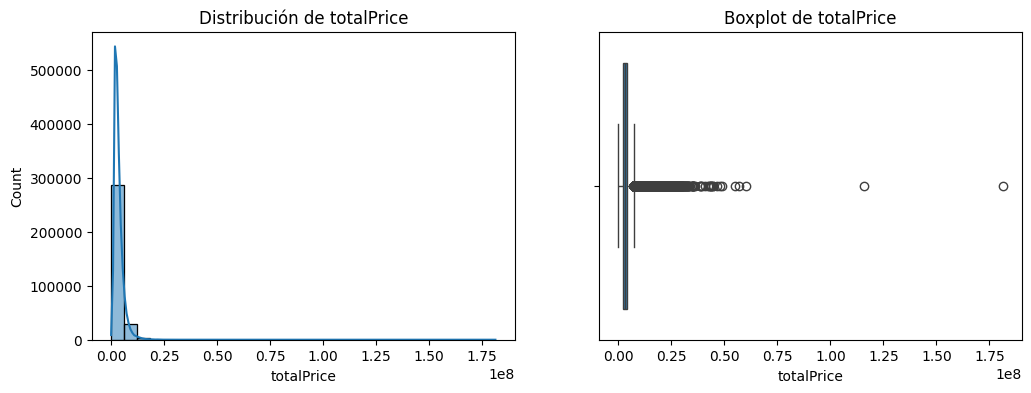

Variable price tiene un p-valor de normalidad de 0.0


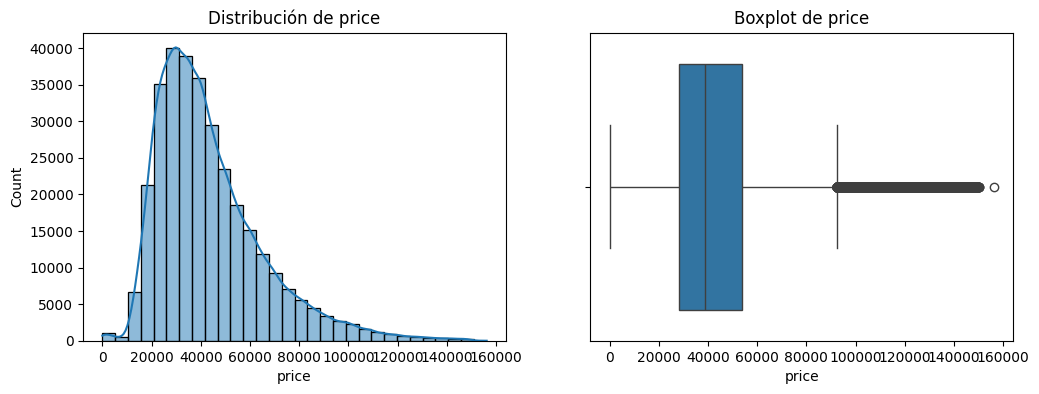

Variable square tiene un p-valor de normalidad de 0.0


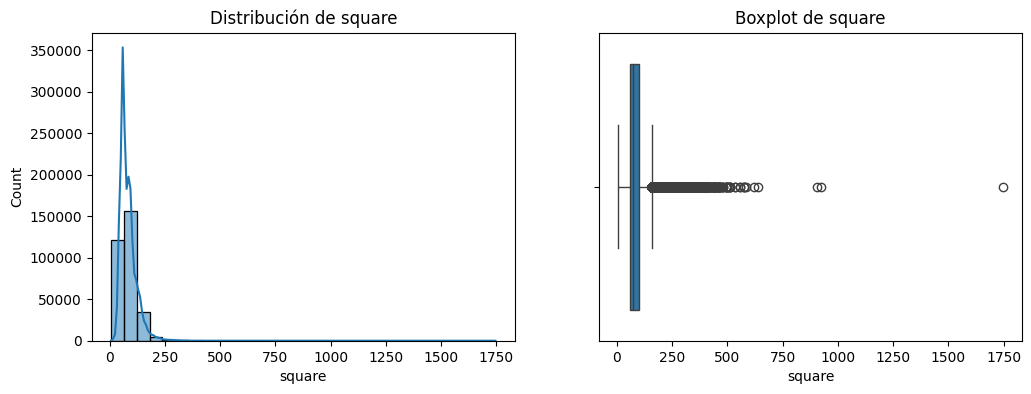

Variable livingRoom tiene un p-valor de normalidad de 0.0


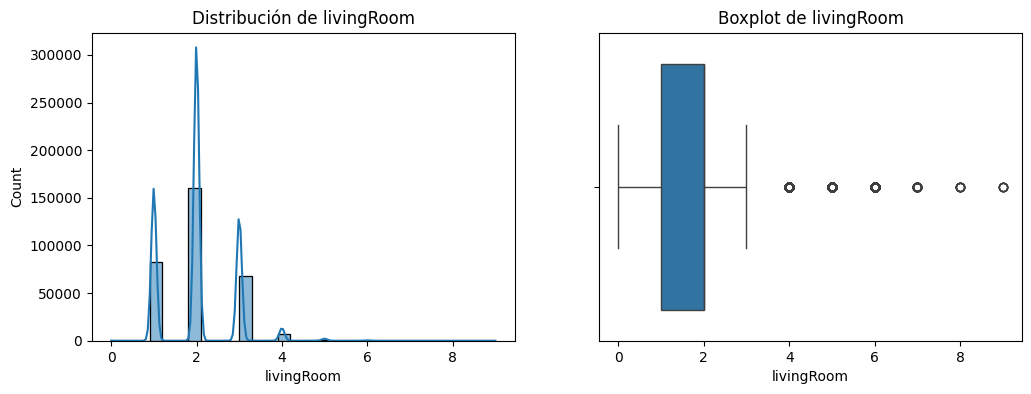

Variable drawingRoom tiene un p-valor de normalidad de 0.0


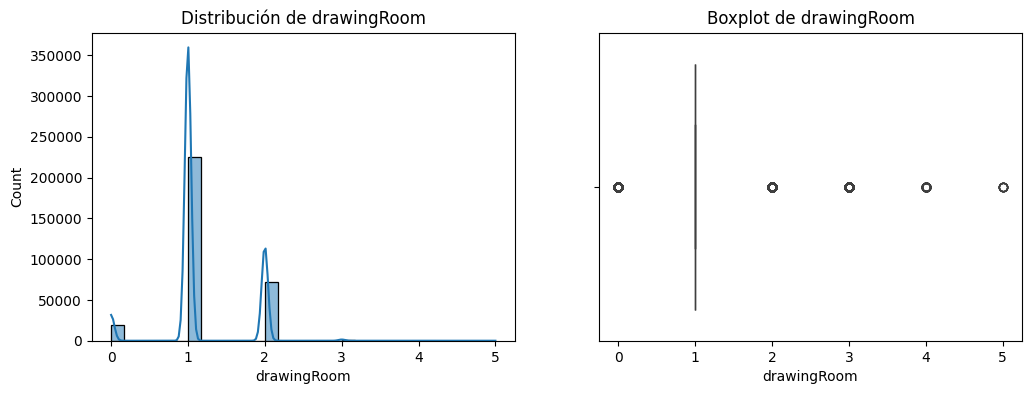

Variable kitchen tiene un p-valor de normalidad de 0.0


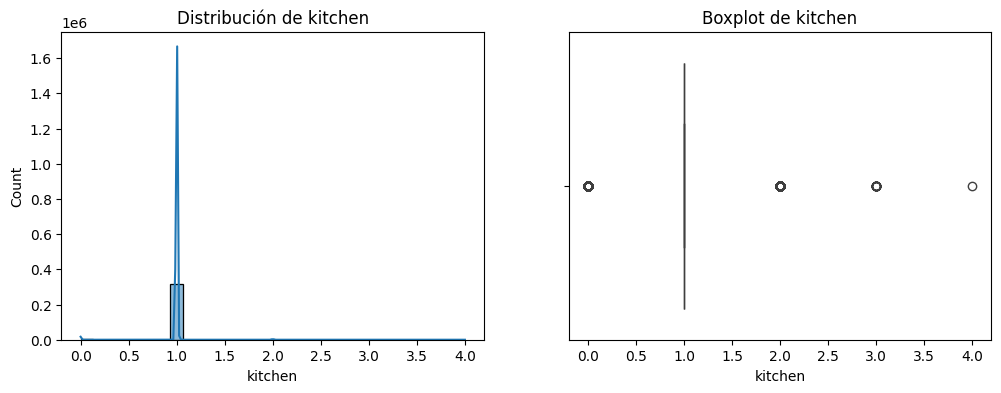

Variable bathRoom tiene un p-valor de normalidad de 0.0


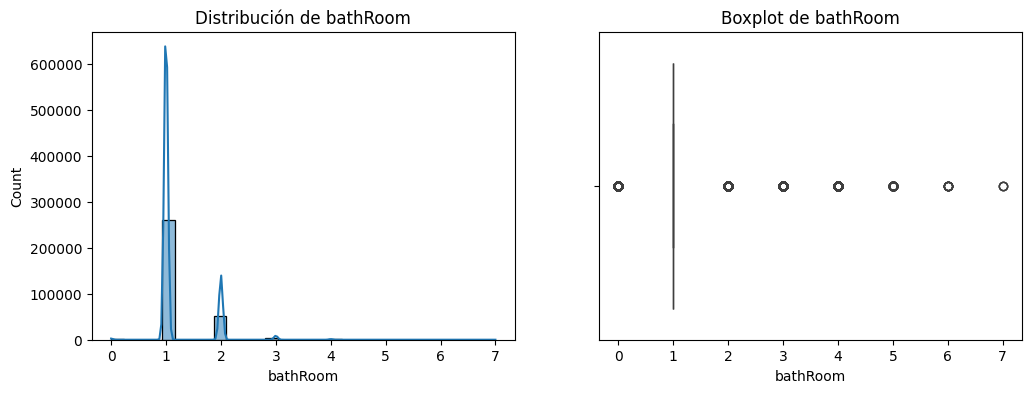

Variable constructionTime tiene un p-valor de normalidad de 0.0


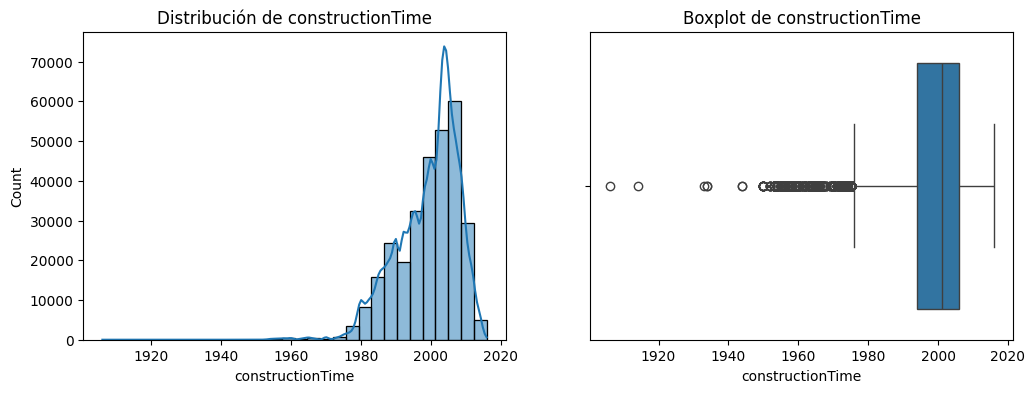

Variable ladderRatio tiene un p-valor de normalidad de 0.0


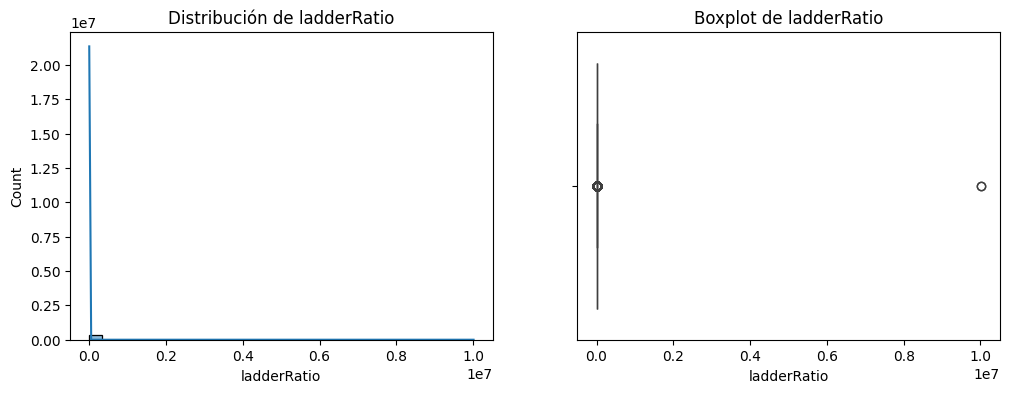

Variable communityAverage tiene un p-valor de normalidad de 0.0


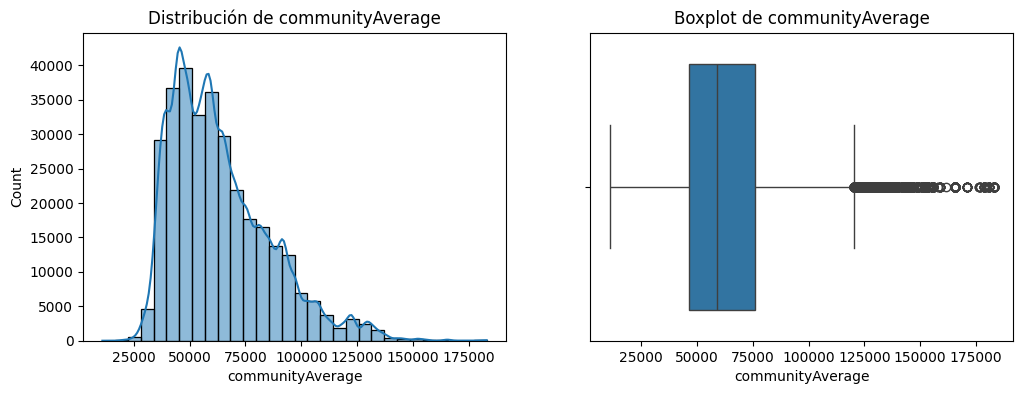

In [ ]:
def primer_paso_outliers(df, lista_columnas: list[str]):
  '''
  Debe hacerse para columnas numericas
  '''
  for col in lista_columnas:
    # Chequeo de normalidad -> ya que es muy comun en outliers para despues transformar o no los datos
    print(f'Variable {col} tiene un p-valor de normalidad de {stats.jarque_bera(df[col].dropna()).pvalue}')

    # Visualizamos esa variable
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()
primer_paso_outliers(df, lista_numericas)

In [ ]:
def outliers_IQR(df, columna, severos=False):
    '''
    Debe hacerse solo para columnas numericas
    '''
    q_IQR = 3 if severos else 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - q_IQR * IQR
    limite_superior = Q3 + q_IQR * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    mask_outliers = (df[columna] < limite_inferior) | (df[columna] > limite_superior)
    return outliers, mask_outliers

def detectar_outliers_IQR(df, lista_columnas: list[str], p_valor_threshold=0.05, severos=False, imputo=False):
    '''
    Debe hacerse solo para columnas numericas
    '''
    df_copia = df.copy()
    masks_orig = dict()
    masks_transf = dict()
    for col in lista_columnas:
        mask = df_copia[col].notna()
        # Probamos si la columna sigue una distribucion normal
        print(f'Columna: {col}')
        p_valor = stats.jarque_bera(df_copia.loc[mask,col]).pvalue          # si la muestra es muy grande, usar stats.normaltest()
        print(f'P-valor de la prueba de normalidad: {p_valor}. {"" if p_valor > p_valor_threshold else "No "}se puede asumir normalidad.')

        # Contamos los outliers en la distribucion original
        outliers_orig, mask_outliers_orig = outliers_IQR(df_copia, col, severos=severos)
        q_outliers_original = outliers_orig.shape[0]
        print(f'Numero de outliers IQR detectados en la distribucion original: {q_outliers_original}')

        if p_valor > p_valor_threshold:
            mask_outliers_transf = None
            # Imputo si corresponde
            if imputo:
                mediana = df_copia.loc[~mask_outliers_orig, col].median()
                df_copia.loc[mask_outliers_orig == True, col] = mediana

        # Si la columna no sigue una distribución normal, aplicamos una transformacion
        else:
            minimo = df_copia[col].min()
            if minimo > 0:
                metodo = 'boxcox'
                data_bc, lambda_bc = stats.boxcox(df_copia.loc[mask, col])
                df_copia.loc[mask, metodo + '_' + col] = data_bc
            else:
                metodo = 'yeojohnson'
                data_yeo, lambda_yeo = stats.yeojohnson(df_copia.loc[mask, col])
                df_copia.loc[mask, metodo + '_' + col] = data_yeo
            outliers_transf, mask_outliers_transf = outliers_IQR(df_copia, metodo + '_' + col, severos=severos)
            q_outliers_transf = outliers_transf.shape[0]
            print(f'Metodo de transformacion aplicado: {metodo}')
            print(f'Numero de outliers IQR detectados en la distribucion transformada: {q_outliers_transf}')

            # Imputo si corresponde
            if imputo:
                mediana = df_copia.loc[~mask_outliers_transf, col].median()
                df_copia.loc[mask_outliers_transf == True, col] = mediana
        masks_orig[col] = mask_outliers_orig
        masks_transf[col] = mask_outliers_transf
        print()
    df_copia = df_copia.loc[:,lista_columnas]
    return df_copia, masks_orig, masks_transf

print('Outliers comunes')
outliers_comunes = detectar_outliers_IQR(df, lista_numericas, p_valor_threshold=0.05, severos=False, imputo=False)
print('Outliers severos')
outliers_severos = detectar_outliers_IQR(df, lista_numericas, p_valor_threshold=0.05, severos=True, imputo=False)

Outliers comunes
Columna: Lng
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 8107
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: Lat
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 6799
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: tradeTime
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 6


/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:1186: UserWarning: The optimal lambda is 352.8660206353974, but the returned lambda is the constrained optimum to ensure that the maximum or the minimum of the transformed data does not overflow in <class 'numpy.float64'>.
  lmax = boxcox_normmax(x, method='mle', optimizer=optimizer)


Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 6

Columna: DOM
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 14895
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: followers
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 31339
Metodo de transformacion aplicado: yeojohnson
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: totalPrice
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 15730
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 6082

Columna: price
P-valor de la prueba de normalidad: 0.0. No se puede as

/usr/local/lib/python3.12/dist-packages/scipy/stats/_morestats.py:1186: UserWarning: The optimal lambda is 352.8660206353974, but the returned lambda is the constrained optimum to ensure that the maximum or the minimum of the transformed data does not overflow in <class 'numpy.float64'>.
  lmax = boxcox_normmax(x, method='mle', optimizer=optimizer)


Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 4

Columna: DOM
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 5505
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: followers
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 15566
Metodo de transformacion aplicado: yeojohnson
Numero de outliers IQR detectados en la distribucion transformada: 0

Columna: totalPrice
P-valor de la prueba de normalidad: 0.0. No se puede asumir normalidad.
Numero de outliers IQR detectados en la distribucion original: 4593
Metodo de transformacion aplicado: boxcox
Numero de outliers IQR detectados en la distribucion transformada: 465

Columna: price
P-valor de la prueba de normalidad: 0.0. No se puede asumi

In [157]:
df.shape

(318819, 29)

In [165]:
import datetime
# Quitamos
df.loc[outliers_severos[2]['tradeTime']]['tradeTime'].apply(lambda x: datetime.datetime.fromordinal(x))

,tradeTime
94502,2002-06-01
126849,2002-07-10
127021,2002-07-06
223738,2003-07-31


Vemos que las distribuciones de los valores no son nada fuera de lo esperado. Hay outliers en las variables de la distribucion transformada pero se deben a valores anomalos no errores.

Cuando buscamos valores severos en la distribucion transformada, que son valores que nos deberian preocupar, vemos que la mayoria no tiene, o tienen muy pocos, pero se corresponden con lo que vimos arriba en los graficos y anteriormente tambien con los .value_counts() de variables discretas (ya sea cuantitativas discretas o categoricas). Un ejemplo seria una propiedad con 12 living rooms, lo cual es un dato verdadero, coherente, pero muy poco usual.

Por eso, tomamos la decision que lo mejor va a ser para los outliers severos (que son practicamente todos en el extremos superior de la distribucion) en la distribucion transformada, reemplazarlos por el maximo valor no outlier (o sea el limite superior de la caja).

Para los casos de bathRoom y drawingRoom, que son variables discretas, como la frecuencia del valor 1 hizo que la caja del boxplot sea solo el valor 1, vamos a imputar reemplazamos los outliers superiores (ej: 7 baños) por un valor superior que mantenga el sentido comun (ej: 3 baños), con el objetivo de tampoco distorsionar y afectar la capacidad predictiva del modelo con valores discretos con un numero sumamente pequeño de muestras.

## Agregamos una nueva variable: distancia al subte

In [135]:
df_propiedades = pd.DataFrame({
    'latitud': df['Lat'],
    'longitud': df['Lng']
})

df_estaciones = pd.DataFrame({
    'latitud': df_subte['Latitud'],
    'longitud': df_subte['Longitud']
})

# Radio medio de la Tierra en kilómetros
R_KM = 6371


# Prepara los datos de las estaciones para el BallTree (en RADIANES)
# BallTree con métrica Haversine espera datos en radianes
estaciones_rad = np.radians(df_estaciones[['latitud', 'longitud']].values)

# Crea el BallTree para búsquedas eficientes de vecinos
tree = BallTree(estaciones_rad, leaf_size=15, metric='haversine')

# Prepara los datos de las propiedades para la búsqueda (en RADIANES)
propiedades_rad = np.radians(df_propiedades[['latitud', 'longitud']].values)

# Realiza la consulta: encuentra la 1 (k=1) distancia más cercana
# 'distances' devuelve la distancia en RADIANES
distancias_rad, _ = tree.query(propiedades_rad, k=1)

# Convierte la distancia de radianes a kilómetros (multiplicando por el radio de la Tierra)
df_propiedades['distancia_km_a_subte_mas_cercano'] = distancias_rad.flatten() * R_KM

print("Resultado final (las primeras 5 propiedades con su distancia mínima):\n")
print(df_propiedades.head())

Resultado final (las primeras 5 propiedades con su distancia mínima):

     latitud    longitud  distancia_km_a_subte_mas_cercano
0  40.019520  116.475489                          0.733077
1  39.881534  116.453917                          0.707238
2  39.877145  116.561978                          2.391765
3  40.076114  116.438010                          2.150789
4  39.886229  116.428392                          0.763286


In [141]:
df = pd.concat([df, df_propiedades], axis=1)

In [146]:
lista_numericas.append('distancia_km_a_subte_mas_cercano')

## Analizamos las hipotesis

In [ ]:
# Hipótesis 1: Los departamentos de menos ambientes presentan un precio por m² más alto que los de mayor tamaño.

<Axes: xlabel='livingRoom', ylabel='price'>

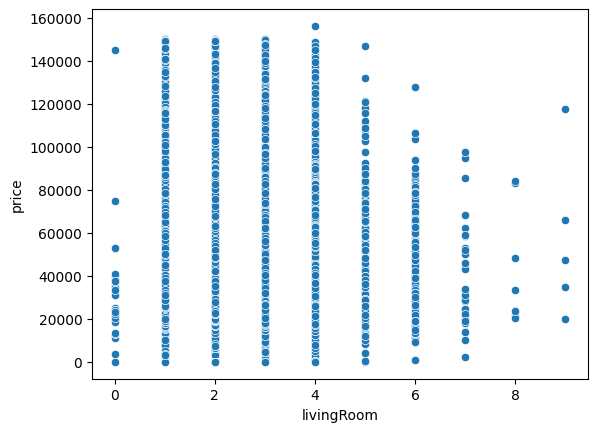

In [ ]:
sns.scatterplot(data=df, x='livingRoom', y='price')

In [ ]:
habitaciones = df['livingRoom'].unique().tolist()
habitaciones.sort()

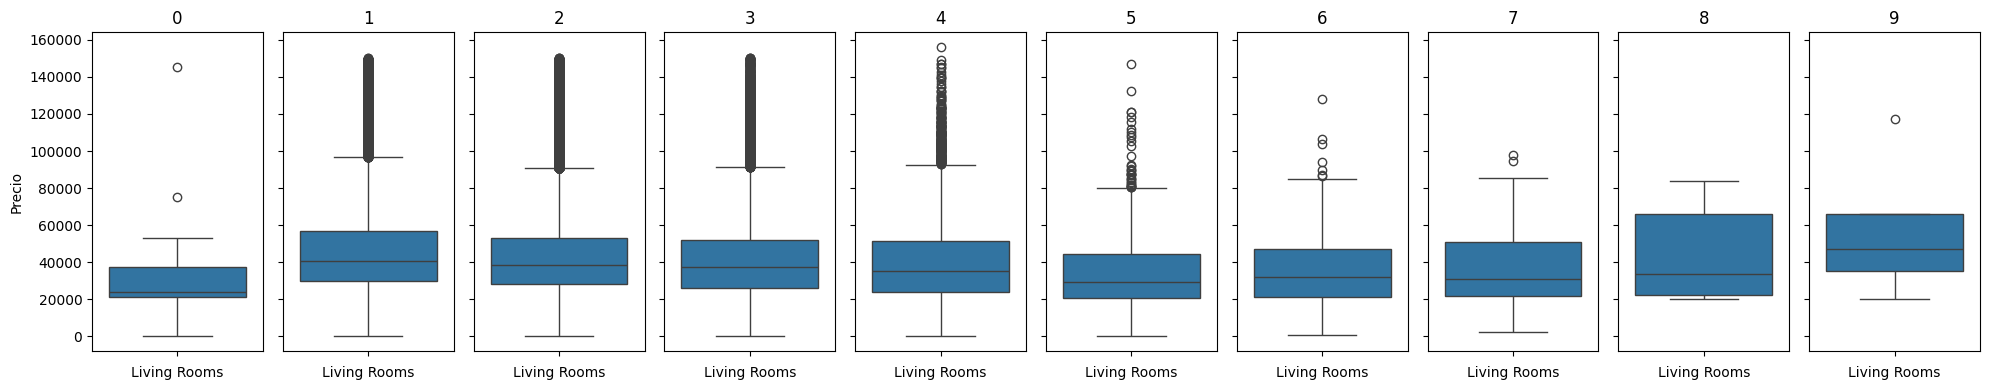

In [ ]:
n_habitaciones = len(habitaciones)
n_cols = 10  # Número de columnas deseadas (10 subplots en una fila)
n_rows = 1  # Calcula el número de filas

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharey=True)
axes = axes.flatten() # Para poder iterar sobre ellos fácilmente

for i, habitacion in enumerate(habitaciones):
    sns.boxplot(data=df.loc[df['livingRoom']==habitacion, 'price'], ax=axes[i])
    axes[i].set_title(f'{habitacion}')
    axes[i].set_ylabel('Precio')
    axes[i].set_xlabel('Living Rooms')


# Ocultar los subplots vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Conclusion preliminar hipotesis 1:

No hay diferencias visualmente significativas. Si, parece haber un descenso gradual en la mediana y los limites de la caja a medida que se pasa de 1 a 6 habitaciones.

Las de 0, 7, 8 y 9 son cajas con muy pocos datos por lo que presentan una variabilidad que no es util para el analisis, y por ende decidimos no sacar conclusiones acerca de ellas.

In [ ]:
# Hipótesis 2: La superficie es el factor principal del precio total.

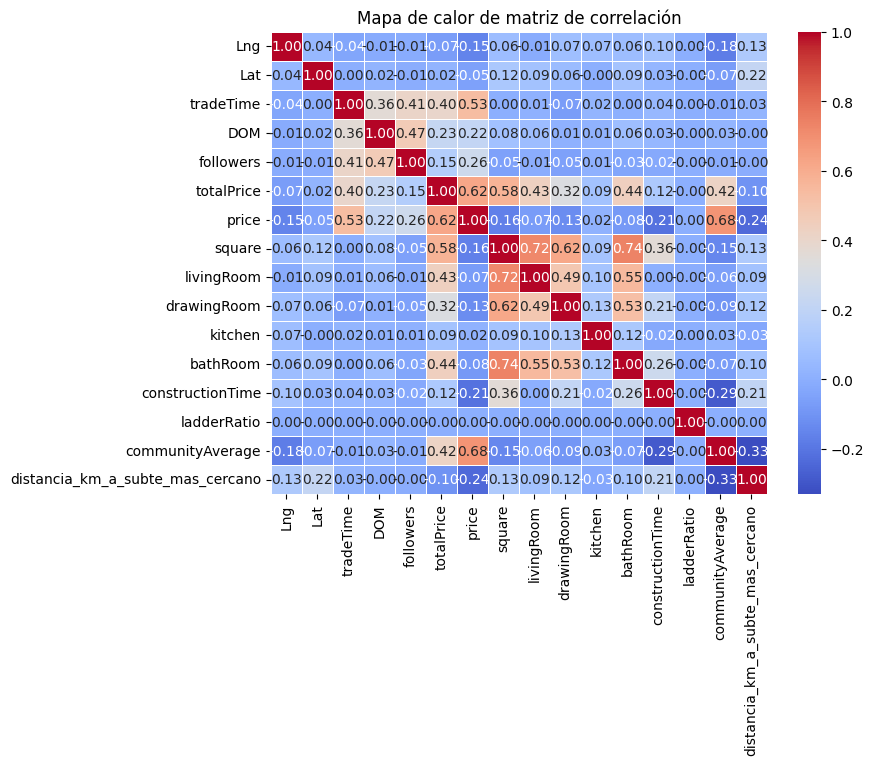

In [147]:
corr_matrix = df[lista_numericas].corr()

_ = plt.figure(figsize=(8, 6))
_ = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
_ = plt.title('Mapa de calor de matriz de correlación')
plt.show()

In [ ]:
print(corr_matrix['totalPrice'])

Lng                -0.070036
Lat                 0.019941
tradeTime           0.400807
DOM                 0.225340
followers           0.152645
totalPrice          1.000000
price               0.622614
square              0.575849
livingRoom          0.434316
drawingRoom         0.322709
kitchen             0.086426
bathRoom            0.442436
constructionTime    0.123158
ladderRatio        -0.001064
communityAverage    0.421396
Name: totalPrice, dtype: float64


In [ ]:
df['totalPrice'].quantile(0.95)

np.float64(7525569.449999886)

<Axes: xlabel='square', ylabel='totalPrice'>

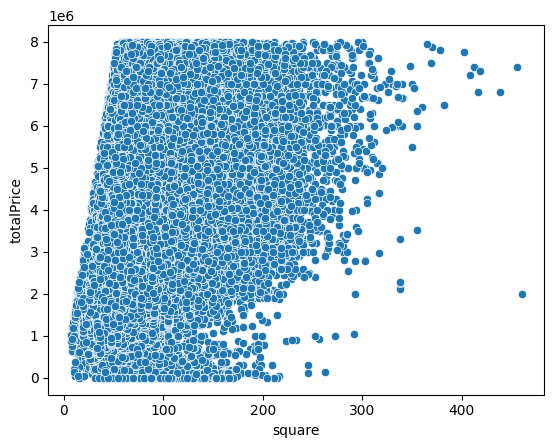

In [ ]:
# Limitamos para sacar dos datos que cambian la escala del grafico
sns.scatterplot(data=df[df['totalPrice']<8000000], x='square', y='totalPrice')

Conclusion preliminar de la hipotesis 2:

Vemos que la superficie es la que mas correlacion tiene con el precio total (a excepcion de precio por m^2 que esta correlacionada de manera directa por ser una construccion de ambas).

En el grafico de puntos vemos que hay cierta relacion entre las variables y que las limites inferiores y superiores parecen crecer a medida que aumenta la superficie.

In [ ]:
# Hipótesis 3: La condición de renovación tiene un gran impacto en el precio total

In [86]:
condiciones = df['renovationCondition'].unique().tolist()
condiciones.sort()
condiciones

[1, 2, 3, 4]

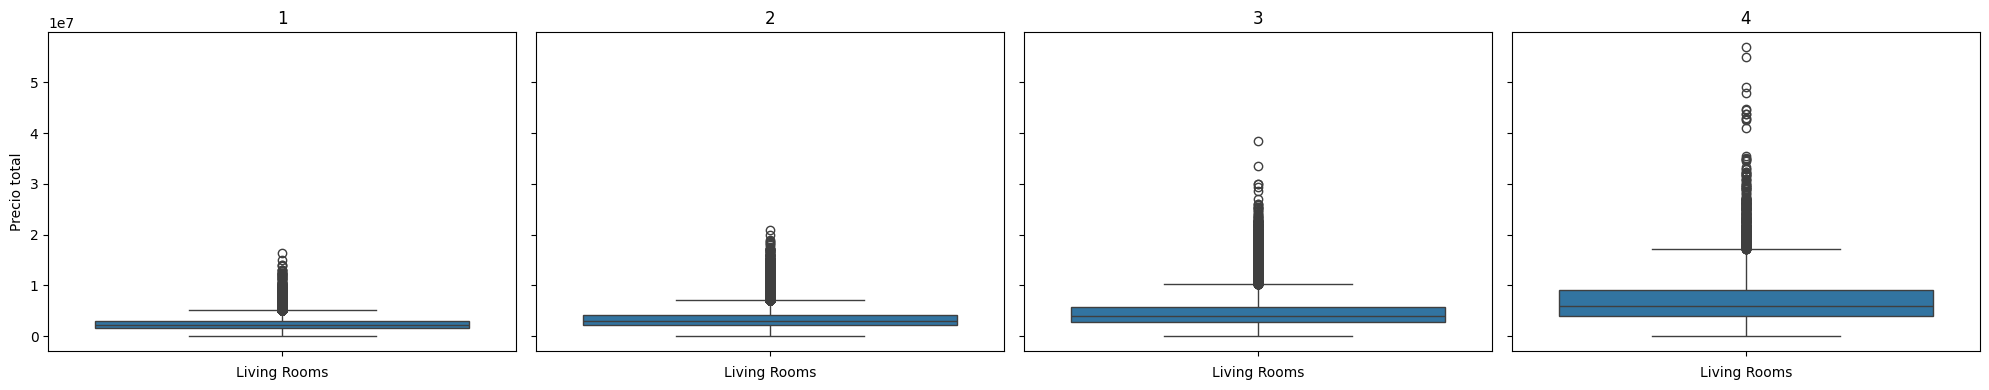

In [89]:
n_condiciones = len(condiciones)
n_cols = 4  # Número de columnas deseadas (4 subplots en una fila)
n_rows = 1  # Calcula el número de filas

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharey=True)
axes = axes.flatten() # Para poder iterar sobre ellos fácilmente

for i, condicion in enumerate(condiciones):
    sns.boxplot(data=df.loc[df['livingRoom']==condicion, 'totalPrice'], ax=axes[i])
    axes[i].set_title(f'{condicion}')
    axes[i].set_ylabel('Precio total')
    axes[i].set_xlabel('Living Rooms')


# Ocultar los subplots vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [91]:
df['renovationCondition'].value_counts(normalize=True)

,proportion
renovationCondition,
1,0.372437
4,0.368353
3,0.242304
2,0.016906


Conclusion preliminar hipotesis 3:

Es dificil de determinar, pero sí da la sensacion de que a medida de que la propiedad esta en mejores condiciones empieza a tener valores mas altos.

In [93]:
# Hipótesis 4: La cantidad de seguidores tiene una alta correlacion con el precio por m².

In [94]:
print(corr_matrix['price'])

Lng                -0.153513
Lat                -0.052046
tradeTime           0.534880
DOM                 0.215391
followers           0.257137
totalPrice          0.622614
price               1.000000
square             -0.164788
livingRoom         -0.073860
drawingRoom        -0.126406
kitchen             0.016810
bathRoom           -0.080820
constructionTime   -0.210991
ladderRatio         0.001107
communityAverage    0.683755
Name: price, dtype: float64


<Axes: xlabel='followers', ylabel='price'>

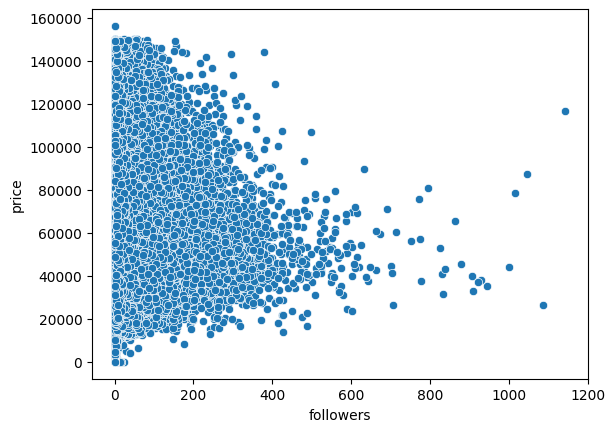

In [96]:
sns.scatterplot(data=df, x='followers', y='price')

Conclusion preliminar hipotesis 4:

Vemos que hay algo de correlacion entre variables pero no lo suficiente para explicar demasiado el precio por m^2. En el grafico vemos que a medida que aumentan los seguidores se tiende a propiedades de precios por m^2 intermedios.

In [ ]:
# Hipótesis 5: Hay un impacto en el precio por m² por la cercania al metro.

In [ ]:
pip install pandas folium

Visualizamos los subtes de la ciudad

In [153]:
import folium
from folium.plugins import HeatMap

# Coordenadas aproximadas del centro de Beijing
lat_centro = 39.9042
lon_centro = 116.4074

# 1. Crear el mapa base
mapa_estaciones = folium.Map(location=[lat_centro, lon_centro],
                             zoom_start=13,
                             tiles='OpenStreetMap') # Un estilo visual claro para destacar los puntos

# 2. Iterar sobre cada fila del DataFrame para añadir un marcador
for index, estacion in df_subte.iterrows():
    # Usamos folium.Marker para crear un punto en el mapa
    folium.Marker(
        location=[estacion['Latitud'], estacion['Longitud']],
        # El 'popup' es el texto que aparece al hacer clic en el marcador
        popup=f"<b>{estacion['Estacion']}</b>",
        # El 'tooltip' es el texto que aparece al pasar el ratón por encima
        tooltip=estacion['Estacion'],
        # Podemos personalizar el ícono para que sea temático
        icon=folium.Icon(color='red', icon='subway', prefix='fa')
    ).add_to(mapa_estaciones)

mapa_estaciones

<Axes: xlabel='distancia_km_a_subte_mas_cercano', ylabel='price'>

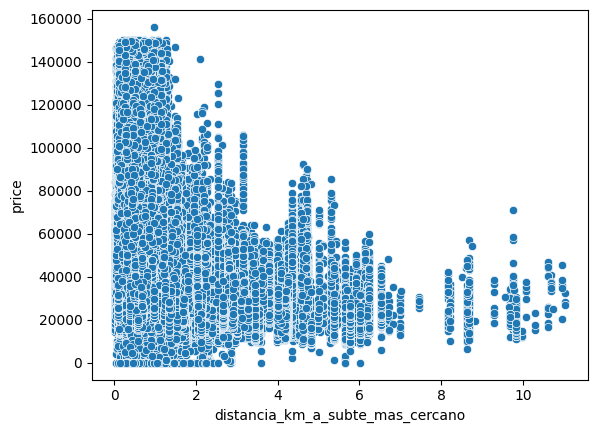

In [154]:
sns.scatterplot(data=df, x='distancia_km_a_subte_mas_cercano', y='price')

Conclusion preliminar 5:

Identificamos primero visualizando los subtes que los mismos estan esparcidos por toda la ciudad y el area suburbana, por lo que descartamos la asociacion de que estaciones de subtes representen unicamente zonas centricas.

Aclarado eso, vemos que las propiedades que estan cerca de un subte tienen precios muy variables. Pueden ser propiedades sumamente baratas o sumamente caras. Ademas, esto sí quizá relacionado con la ubicacion estrategica en zonas urbanas del subtem a medida que nos alejamos de un subte dejamos de tener propiedades de alto precio x m^2.

In [ ]:
# Hipotesis 6: hay determinados tipos de construcciones/edificios que solo se relacionan con ciertos rangos de construcción de los edificios

In [122]:
df['buildingType'].value_counts()

,count
buildingType,
4.0,172405
1.0,84541
3.0,59715
2.0,137


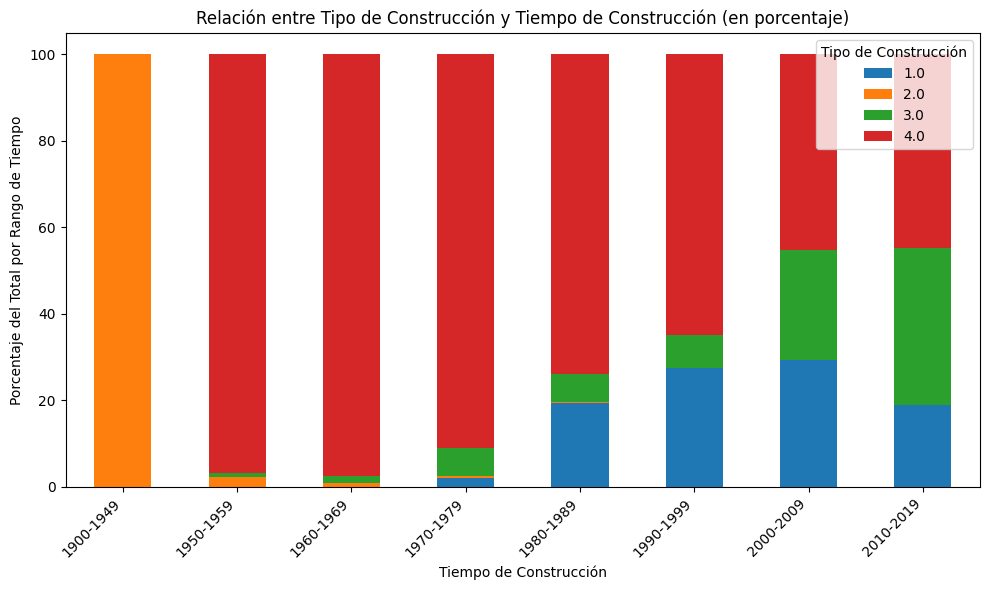

In [121]:
# Armamos df sin NaNs
df_cleaned = df.dropna(subset=['constructionTime', 'buildingType']).copy()

df_cleaned['constructionTime'] = df_cleaned['constructionTime'].astype(int)

# Creamos intervalos para 'constructionTime'
bins = [1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
labels = ['1900-1949', '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019']
df_cleaned['constructionTime_bin'] = pd.cut(df_cleaned['constructionTime'], bins=bins, labels=labels, right=False)

# Hacemos crosstab
crosstab_data = pd.crosstab(df_cleaned['constructionTime_bin'], df_cleaned['buildingType'], normalize='index') * 100

ax = crosstab_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Relación entre Tipo de Construcción y Tiempo de Construcción (en porcentaje)')
plt.xlabel('Tiempo de Construcción')
plt.ylabel('Porcentaje del Total por Rango de Tiempo')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Construcción')
plt.tight_layout()
plt.show()

Conclusion preliminar 6:

Considerando que los numeros se correspondena los siguientes tipos de edificio: "tower(1), bungalow(2), combination of plate and tower(3), plate (4)", podemos ver que antes se construian mas edificios de tipo 'bungalow' que en la actualidad ha desaparecido y desde hace decadas que viene habiendo un descenso de edificios tipo 'plate' y aumentando la combinacion de torres comunes con tipo 'plate'.

## Tratamiento de outliers

Ver despues

In [ ]:
pip install geopy

In [ ]:
la = df.loc[0,['Lat','Lng']].values[0]
lo = df.loc[0,['Lat','Lng']].values[1]

In [ ]:
la, lo

In [ ]:
from geopy.geocoders import Nominatim
# Provide a custom user agent string
geolocator = Nominatim(user_agent="geo_analysis_app")
location = geolocator.reverse((la,lo))
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

In [ ]:
location.raw['address']['town']

In [ ]:
la = df.loc[1,['Lat','Lng']].values[0]
lo = df.loc[1,['Lat','Lng']].values[1]
geolocator = Nominatim(user_agent="geo_analysis_app")
location = geolocator.reverse((la,lo))
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

In [ ]:
location.raw['address']

In [ ]:
ciudad = []
for lat,long in df.loc[:20,['Lat','Lng']].values:
  geolocator = Nominatim(user_agent="geo_analysis_app")
  location = geolocator.reverse((lat,long))
  ciudad.append(location.raw['address']['city'])

In [ ]:
df_primer_registro = df.groupby('Cid').agg(
    Lat=('Lat', 'first'),
    Lng=('Lng', 'first')
).reset_index()

display(df_primer_registro.head())

In [ ]:
df_primer_registro.Cid.nunique()/60

In [ ]:
prueba = pd.concat([df.loc[:20], pd.Series(ciudad)], axis=1).groupby('Cid')[0].count()
len(prueba), prueba.index.nunique()